In [16]:
import os
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
from multiprocessing import Pool, cpu_count
from collections import Counter
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.Chem.Scaffolds import MurckoScaffold

def smiles_to_ecfp(smiles_list, radius=2, n_bits=1024):
    """将SMILES转换为ECFP指纹"""
    fingerprints = []
    valid_smiles = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
            fingerprints.append(fp)
            valid_smiles.append(smi)
        else:
            print(f"无法解析SMILES: {smi}")
    return fingerprints, valid_smiles

def tanimoto_similarity(args):
    """计算Tanimoto相似性"""
    i, j, fps = args
    return i, j, DataStructs.TanimotoSimilarity(fps[i], fps[j])

def tanimoto_distance_matrix(fingerprints):
    """计算Tanimoto相似性矩阵并转换为距离矩阵"""
    num = len(fingerprints)
    if num == 1:
        return np.array([[0]])
    
    distance_matrix = np.ones((num, num))  # 先填充为1
    pool = Pool(min(4, cpu_count()))  # 限制最大进程数
    results = pool.map(tanimoto_similarity, [(i, j, fingerprints) for i in range(num) for j in range(i + 1, num)])
    pool.close()
    pool.join()
    
    for i, j, sim in results:
        distance_matrix[i, j] = distance_matrix[j, i] = 1 - sim  # 计算距离
    return distance_matrix

def hierarchical_clustering(distance_matrix, labels, output_csv, t=0.7):
    """使用层次聚类并输出CSV文件"""
    condensed_dist_matrix = pdist(distance_matrix, metric="euclidean")
    linkage_matrix = sch.linkage(condensed_dist_matrix, method='average')
    clusters = sch.fcluster(linkage_matrix, t=t, criterion='distance')
    df = pd.DataFrame({"SMILES": labels, "Cluster": clusters})
    df.to_csv(output_csv, index=False)
    print(f"聚类结果已保存到 {output_csv}")
    
    # 统计聚类信息
    print("聚类统计信息：")
    print(df["Cluster"].value_counts().sort_index())
    
    # 确保输出目录存在
    output_dir = os.path.dirname(output_csv)
    os.makedirs(output_dir, exist_ok=True)
    
    # 绘制树状图
    plt.figure(figsize=(10, 7))
    if len(labels) > 500:
        sch.dendrogram(linkage_matrix, no_labels=True)
    else:
        sch.dendrogram(linkage_matrix, labels=labels, leaf_rotation=90)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Compound Index')
    plt.ylabel('Distance')
    
    # 保存图像
    for ext in ['pdf', 'svg', 'png', 'tiff']:
        plt.savefig(os.path.join(output_dir, f"dendrogram.{ext}"), format=ext, dpi=300, bbox_inches='tight')
    print("树状图已保存")
    plt.show()

def extract_scaffold(smiles):
    """提取Murcko Scaffold"""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold)
    return None

def analyze_cluster_scaffolds(df):
    """分析每个簇的scaffold"""
    cluster_scaffolds = {}
    for cluster, group in df.groupby("Cluster"):
        scaffolds = [extract_scaffold(smiles) for smiles in group["SMILES"]]
        scaffolds = [s for s in scaffolds if s]
        if scaffolds:
            most_common_scaffold = Counter(scaffolds).most_common(1)[0][0]
        else:
            most_common_scaffold = "No scaffold"
        cluster_scaffolds[cluster] = most_common_scaffold
        print(f"Cluster {cluster}: 最常见的scaffold = {most_common_scaffold}")
    return cluster_scaffolds

In [17]:
# 读取CSV文件
input_csv = "/export/home/zhaoyh/HXY/choose.csv"
df = pd.read_csv(input_csv)
smiles_list = df["SMILES"].tolist()

In [18]:
# 计算指纹
fingerprints, valid_smiles = smiles_to_ecfp(smiles_list)

In [19]:
# 计算Tanimoto距离矩阵
distance_matrix = tanimoto_distance_matrix(fingerprints)

聚类结果已保存到 /export/home/zhaoyh/HXY/clusters0305.csv
聚类统计信息：
1    7
2    1
3    1
4    1
Name: Cluster, dtype: int64
树状图已保存


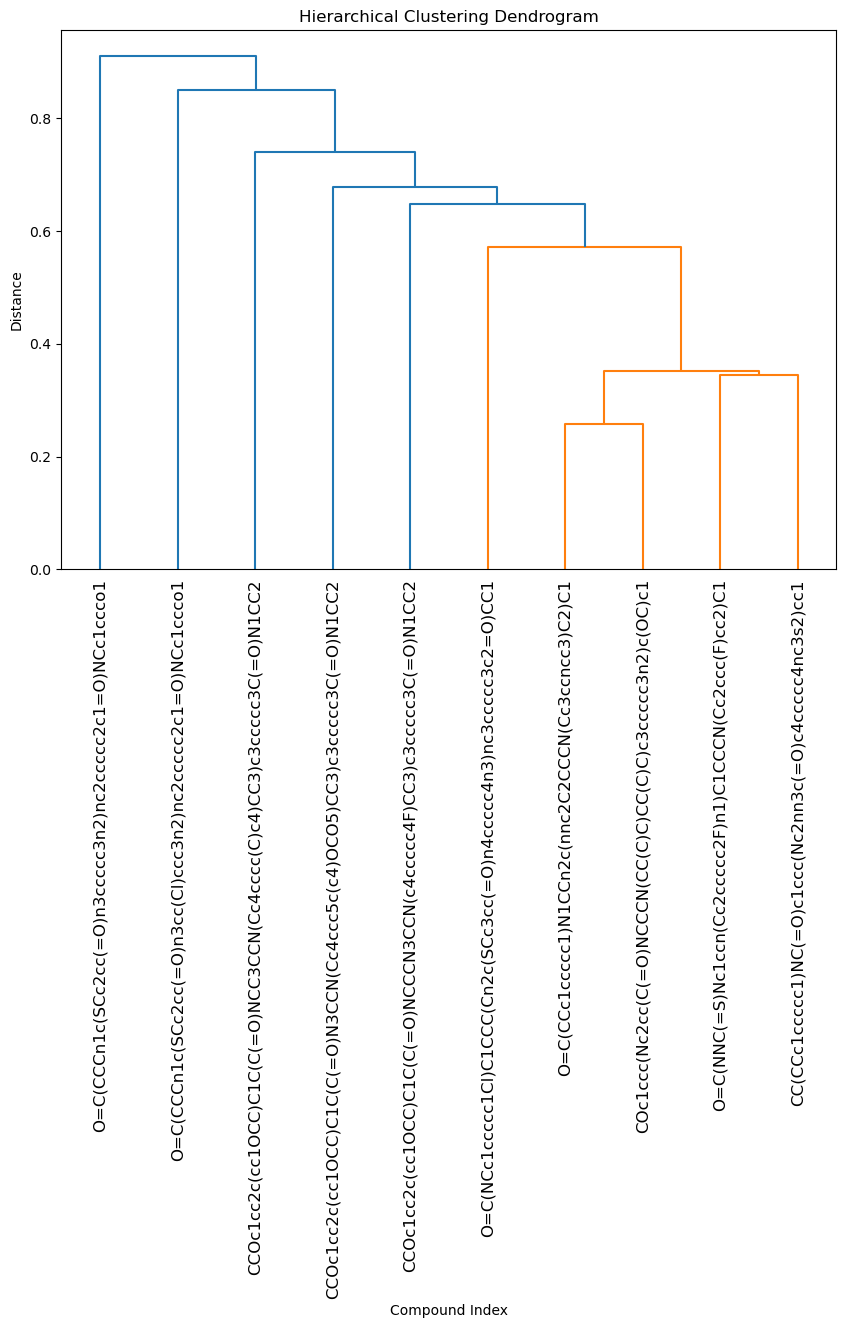

In [20]:
# 层次聚类
output_csv = "/export/home/zhaoyh/HXY/clusters0305.csv"
hierarchical_clustering(distance_matrix, valid_smiles, output_csv, t=0.7)

In [ ]:
# 读取聚类结果
if os.path.exists(output_csv):
    df_clusters = pd.read_csv(output_csv)
    cluster_scaffolds = analyze_cluster_scaffolds(df_clusters)
# 保存scaffold分析结果
    scaffold_df = pd.DataFrame(list(cluster_scaffolds.items()), columns=["Cluster", "Scaffold"])
    scaffold_df.to_csv("/export/home/zhaoyh/HXY/cluster_scaffolds.csv", index=False)
    print("Scaffold分析结果已保存")

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.Chem.Scaffolds import MurckoScaffold
import numpy as np
import scipy.cluster.hierarchy as sch
from multiprocessing import Pool, cpu_count
from collections import Counter
import matplotlib.pyplot as plt
import os

def smiles_to_ecfp(smiles_list, radius=2, n_bits=1024):
    """将SMILES转换为ECFP指纹"""
    fingerprints = []
    valid_smiles = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
            fingerprints.append(fp)
            valid_smiles.append(smi)
        else:
            print(f"无法解析SMILES: {smi}")
    return fingerprints, valid_smiles

def tanimoto_similarity(args):
    """计算Tanimoto相似性"""
    i, j, fps = args
    return i, j, DataStructs.TanimotoSimilarity(fps[i], fps[j])

def tanimoto_distance_matrix(fingerprints):
    """计算Tanimoto相似性矩阵并转换为距离矩阵"""
    num = len(fingerprints)
    distance_matrix = np.zeros((num, num))
    pool = Pool(min(4, cpu_count()))  # 限制最大进程数为4
    results = pool.map(tanimoto_similarity, [(i, j, fingerprints) for i in range(num) for j in range(i + 1, num)])
    pool.close()
    pool.join()
    
    for i, j, sim in results:
        distance_matrix[i, j] = distance_matrix[j, i] = 1 - sim  # 转换为距离
    return distance_matrix

def export_dendrogram_data(linkage_matrix, labels, output_csv):
    """导出树状图数据到CSV文件"""
    linkage_df = pd.DataFrame(linkage_matrix, columns=["Cluster1", "Cluster2", "Distance", "Size"])
    linkage_df["Label1"] = labels[:len(linkage_matrix)]
    linkage_df["Label2"] = labels[:len(linkage_matrix)]
    linkage_df.to_csv(output_csv, index=False)
    print(f"树状图数据已保存到 {output_csv}")

def hierarchical_clustering(distance_matrix, labels, output_csv, t=0.8):
    """使用层次聚类并输出CSV文件"""
    linkage_matrix = sch.linkage(distance_matrix, method='average')
    clusters = sch.fcluster(linkage_matrix, t=t, criterion='distance')  # 设定聚类阈值
    df = pd.DataFrame({"SMILES": labels, "Cluster": clusters})
    df.to_csv(output_csv, index=False)
    print(f"聚类结果已保存到 {output_csv}")
    
    # 输出聚类统计信息
    cluster_sizes = df["Cluster"].value_counts().sort_index()
    print("聚类统计信息：")
    print(cluster_sizes)
    
    # 可视化树状图
    plt.figure(figsize=(10, 7))
    if len(labels) > 500:  # 数据量较大时隐藏标签
        sch.dendrogram(linkage_matrix, no_labels=True)
    else:
        sch.dendrogram(linkage_matrix, labels=labels, leaf_rotation=90)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Compound Index')
    plt.ylabel('Distance')
    
    # 确保输出目录存在
    output_dir = os.path.dirname(output_csv)
    os.makedirs(output_dir, exist_ok=True)
    
    # 保存为多种格式
    for ext in ['pdf', 'svg', 'png', 'tiff']:
        plt.savefig(os.path.join(output_dir, f"dendrogram.{ext}"), format=ext, dpi=300, bbox_inches='tight')
    print("树状图已保存为 PDF、SVG、PNG 和 TIFF 格式")
    
    # 导出树状图数据
    export_dendrogram_data(linkage_matrix, labels, os.path.join(output_dir, "dendrogram_data.csv"))
    
    plt.show()  # 显示树状图

def extract_scaffold(smiles):
    """从SMILES中提取Murcko Scaffold"""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold)
    return None

def analyze_cluster_scaffolds(df):
    """分析每个簇的scaffold"""
    cluster_scaffolds = {}
    for cluster, group in df.groupby("Cluster"):
        scaffolds = [extract_scaffold(smiles) for smiles in group["SMILES"]]
        scaffolds = [s for s in scaffolds if s]  # 过滤掉无效的scaffold
        if scaffolds:
            most_common_scaffold = Counter(scaffolds).most_common(1)[0][0]
        else:
            most_common_scaffold = "No scaffold"
        cluster_scaffolds[cluster] = most_common_scaffold
        print(f"Cluster {cluster}: 最常见的scaffold = {most_common_scaffold}")
    return cluster_scaffolds

In [2]:
# 主程序
if __name__ == "__main__":
    # 1. 从CSV文件读取SMILES
    input_csv = "/export/home/zhaoyh/HXY/choose.csv"
    df = pd.read_csv(input_csv)
    smiles_list = df["SMILES"].tolist()

In [3]:
    # 2. 计算ECFP指纹
    fingerprints, valid_smiles = smiles_to_ecfp(smiles_list)

In [4]:
    # 3. 计算Tanimoto距离矩阵
    distance_matrix = tanimoto_distance_matrix(fingerprints)

/tmp/ipykernel_37343/1164461877.py:54: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(distance_matrix, method='average')


聚类结果已保存到 /export/home/zhaoyh/HXY/clusters03014.csv
聚类统计信息：
1    3
2    3
3    1
4    1
5    1
6    1
Name: Cluster, dtype: int64
树状图已保存为 PDF、SVG、PNG 和 TIFF 格式
树状图数据已保存到 /export/home/zhaoyh/HXY/dendrogram_data.csv


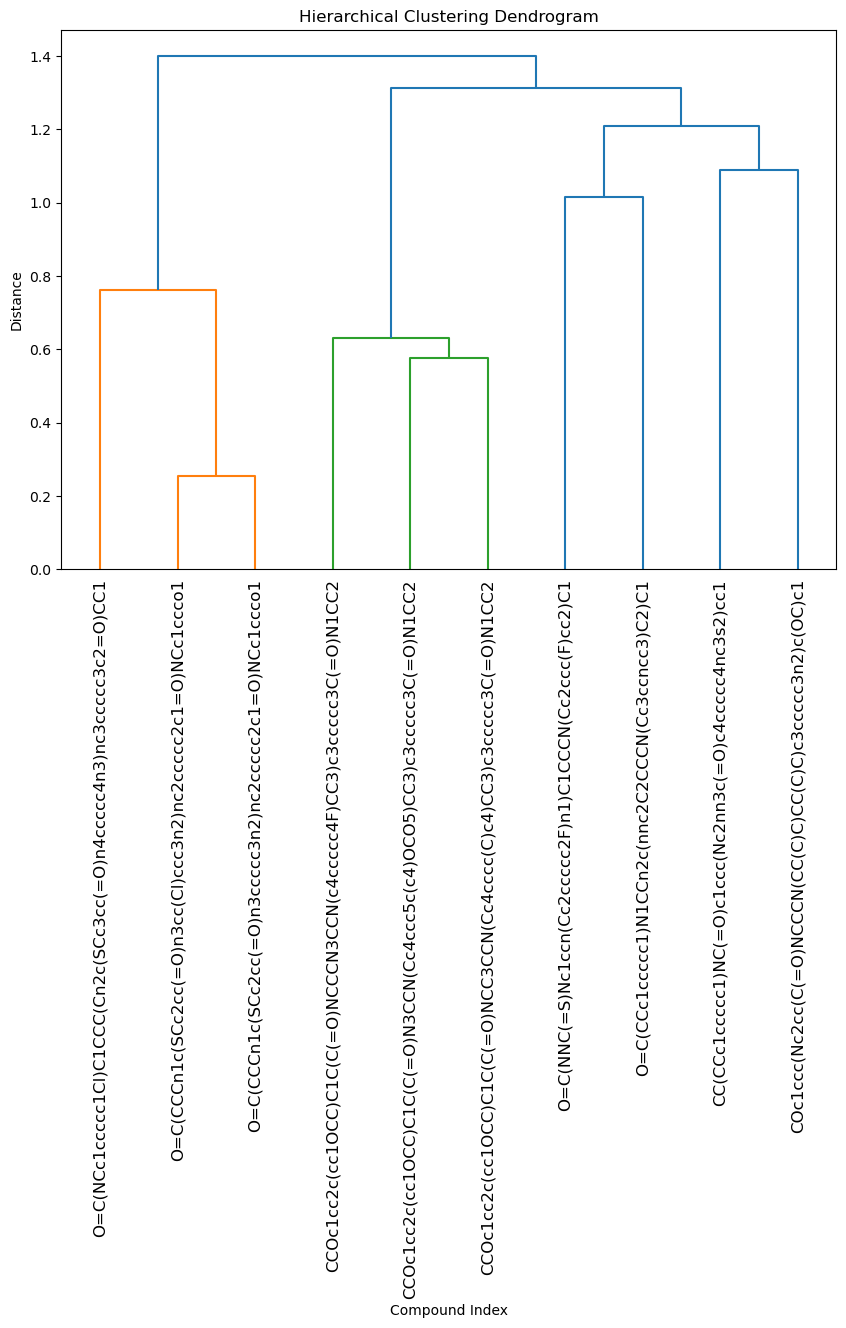

In [6]:
    # 4. 进行层次聚类并保存结果
    output_csv = "/export/home/zhaoyh/HXY/clusters03014.csv"
    hierarchical_clustering(distance_matrix, valid_smiles, output_csv, t=0.8)

In [30]:
    # 5. 分析每个簇的scaffold
    df_clusters = pd.read_csv(output_csv)
    cluster_scaffolds = analyze_cluster_scaffolds(df_clusters)

Cluster 1: 最常见的scaffold = O=C(CCCn1c(SCc2cc(=O)n3ccccc3n2)nc2ccccc2c1=O)NCc1ccco1
Cluster 2: 最常见的scaffold = O=C(C1c2ccccc2C(=O)N2CCc3ccccc3C12)N1CCN(Cc2ccc3c(c2)OCO3)CC1
Cluster 3: 最常见的scaffold = O=C(NNC(=S)Nc1ccn(Cc2ccccc2)n1)C1CCCN(Cc2ccccc2)C1
Cluster 4: 最常见的scaffold = O=C(CCc1ccccc1)N1CCn2c(nnc2C2CCCN(Cc3ccncc3)C2)C1
Cluster 5: 最常见的scaffold = O=C(NCCCc1ccccc1)c1ccc(Nc2nn3c(=O)c4ccccc4nc3s2)cc1
Cluster 6: 最常见的scaffold = c1ccc(Nc2ccc3ccccc3n2)cc1


In [31]:
    # 6. 保存scaffold分析结果
    scaffold_df = pd.DataFrame(list(cluster_scaffolds.items()), columns=["Cluster", "Scaffold"])
    scaffold_df.to_csv("/export/home/zhaoyh/HXY/cluster_scaffolds.csv", index=False)
    print("Scaffold分析结果已保存到 cluster_scaffolds.csv")

Scaffold分析结果已保存到 cluster_scaffolds.csv


In [33]:
import pandas as pd

# 读取TSV文件
try:
    df = pd.read_csv('BindingDB_All_202401.tsv', delimiter='\t', error_bad_lines=False)
except pd.errors.ParserError as e:
    print(f"ParserError: {e}")
    exit()

    
    
    
# 筛选出包含FLT3的行
flt3_data = df[df['Target Name'].str.contains('DNA-dependent protein kinase catalytic subunit')]

# 将数据保存到Excel表格中
flt3_data.to_excel('DNAPK.xlsx', index=False)


/tmp/ipykernel_18593/2050617551.py:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('BindingDB_All_202401.tsv', delimiter='\t', error_bad_lines=False)
b'Skipping line 1338191: expected 194 fields, saw 206\nSkipping line 1338217: expected 194 fields, saw 206\n'
b'Skipping line 1370358: expected 194 fields, saw 206\n'
b'Skipping line 1393022: expected 194 fields, saw 266\n'
b'Skipping line 1796791: expected 194 fields, saw 242\n'
b'Skipping line 1910602: expected 194 fields, saw 242\nSkipping line 1910603: expected 194 fields, saw 242\nSkipping line 1910604: expected 194 fields, saw 242\nSkipping line 1910605: expected 194 fields, saw 242\nSkipping line 1910606: expected 194 fields, saw 242\nSkipping line 1910607: expected 194 fields, saw 242\nSkipping line 1910608: expected 194 fields, saw 242\nSkipping line 1910609: expected 194 fields, saw 242\nSkipping line 1910610: expecte

In [20]:
import pandas as pd  
  
# 尝试读取TSV文件  
try:  
    df = pd.read_csv('BindingDB_All_202401.tsv', delimiter='\t', error_bad_lines=False)  
except pd.errors.ParserError as e:  
    print(f"解析错误: {e}")  
    # 可以选择记录错误日志或进行其他错误处理，而不仅仅是退出  
    # exit()  # 使用更优雅的退出方式，或者根据需求处理  
    raise  # 重新抛出异常，让上层调用者处理  
except FileNotFoundError:  
    print("文件未找到，请检查文件路径是否正确。")  
    raise  # 或者其他错误处理  
except Exception as e:  
    print(f"发生了一个未知错误: {e}")  
    raise  # 或者其他错误处理  
  
# 筛选出包含'5-nucleotidase'的行（注意字符串需要用引号括起来）  
# 假设这里的目标可能是筛选包含'FLT3'的行，但根据您的代码注释，这里使用了'5-nucleotidase'  
# 请确认您想要筛选的确切字符串  
flt3_data = df[df['Target Name'].str.contains('-nucleotidase')]  
  
# 将筛选后的数据保存到Excel表格中  
# 注意文件名从'CD73.xlsx'更改为可能更反映数据内容的名称，例如'FLT3_Binding_Data.xlsx'  
# 如果目标是FLT3，则可能需要调整文件名和筛选条件  
try:  
    flt3_data.to_excel('FLT3_Binding_Data.xlsx', index=False)  
except Exception as e:  
    print(f"保存Excel文件时发生错误: {e}")  
    # 可以选择记录错误日志或进行其他错误处理

/tmp/ipykernel_18593/4056618714.py:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('BindingDB_All_202401.tsv', delimiter='\t', error_bad_lines=False)
b'Skipping line 1338191: expected 194 fields, saw 206\nSkipping line 1338217: expected 194 fields, saw 206\n'
b'Skipping line 1370358: expected 194 fields, saw 206\n'
b'Skipping line 1393022: expected 194 fields, saw 266\n'
b'Skipping line 1796791: expected 194 fields, saw 242\n'
b'Skipping line 1910602: expected 194 fields, saw 242\nSkipping line 1910603: expected 194 fields, saw 242\nSkipping line 1910604: expected 194 fields, saw 242\nSkipping line 1910605: expected 194 fields, saw 242\nSkipping line 1910606: expected 194 fields, saw 242\nSkipping line 1910607: expected 194 fields, saw 242\nSkipping line 1910608: expected 194 fields, saw 242\nSkipping line 1910609: expected 194 fields, saw 242\nSkipping line 1910610: expecte

In [ ]:
#计算分子相似性

In [5]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np
import matplotlib.pyplot as plt


In [6]:
# 读取Excel文件
df = pd.read_excel('AMY.xlsx')
smiles = df['SMILES'].tolist()

# 根据SMILES构建分子对象
mols = [Chem.MolFromSmiles(s) for s in smiles]

# 构建分子指纹特征向量（ECFP）
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in mols]


In [7]:
# 初始化Tanimoto系数列表
tanimoto_coefficients = []

# 计算每对化合物的Tanimoto系数
for i in range(len(fingerprints)):
    for j in range(i + 1, len(fingerprints)):
        tanimoto = DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j])
        tanimoto_coefficients.append(tanimoto)

# 将Tanimoto系数保存到DataFrame并保存到Excel表
tanimoto_df = pd.DataFrame({'Tanimoto Coefficient': tanimoto_coefficients})
tanimoto_df.to_csv('tanimoto_coefficients.csv', index=False)


In [11]:
# 创建bins列表
bins = [x / 20 for x in range(21)]

# 将Tanimoto系数列表根据0-1范围内每0.05平均分为20份
tanimoto_df['Binned Coefficient'] = pd.cut(tanimoto_df['Tanimoto Coefficient'], bins=bins, labels=False)

# 统计每份的数量
counts = tanimoto_df['Binned Coefficient'].value_counts().sort_index()

# 创建保存结果的DataFrame
result_df = pd.DataFrame({'Bin': counts.index, 'Count': counts.values})

# 将结果保存到Excel表
result_df.to_excel('tanimoto_counts.xlsx', index=False)

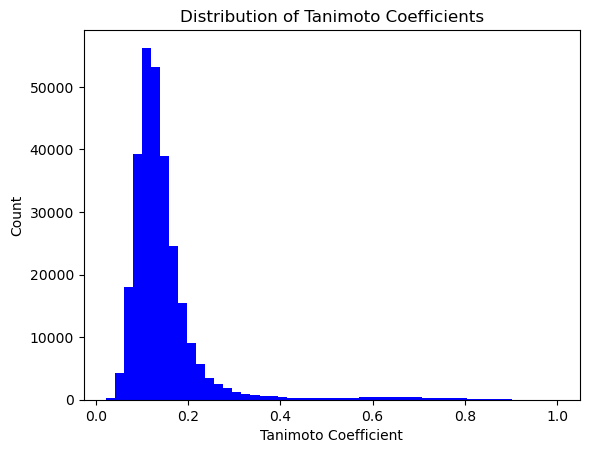

In [10]:
# 绘制Tanimoto系数直方图
plt.hist(tanimoto_coefficients, bins=50, color='blue')
plt.xlabel('Tanimoto Coefficient')
plt.ylabel('Count')
plt.title('Distribution of Tanimoto Coefficients')
plt.show()


In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [2]:
# 读取Excel文件
df = pd.read_csv("UMP.csv")
smiles = df['SMILES'].tolist()

# 根据SMILES构建分子对象
mols = [Chem.MolFromSmiles(s) for s in smiles]

# 构建分子指纹特征向量
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) for mol in mols]
fingerprints_arr = [list(f) for f in fingerprints]


In [3]:
# 执行PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(fingerprints_arr)

# 将PCA结果转换为DataFrame并保存到Excel表
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df.to_excel('pca_results.xlsx', index=False)


In [4]:
# 执行t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(fingerprints_arr)

# 将t-SNE结果转换为DataFrame并保存到Excel表
tsne_df = pd.DataFrame(tsne_result, columns=['t-SNE Dimension 1', 't-SNE Dimension 2'])
tsne_df.to_excel('tsne_results.xlsx', index=False)


/home/rdkit/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/rdkit/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


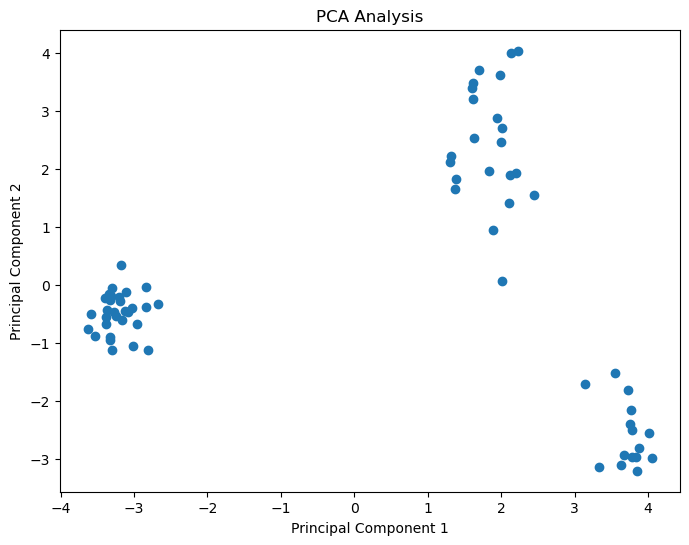

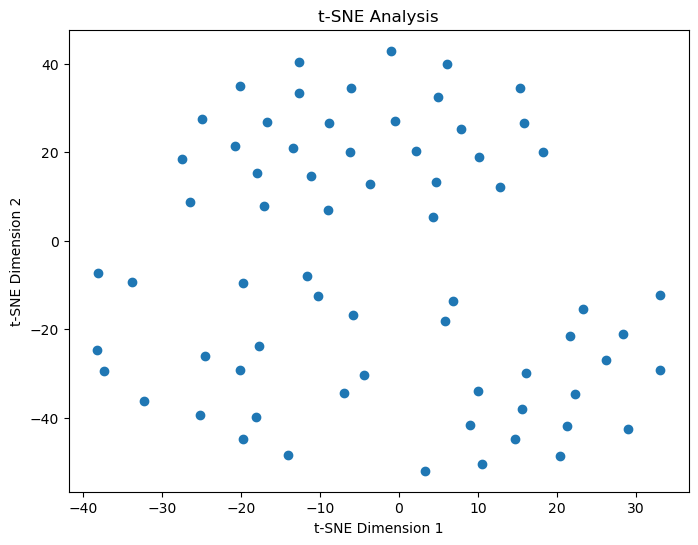

In [5]:
# 绘制PCA结果图
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.title('PCA Analysis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.savefig('pca_plot.png')
plt.show()

# 绘制t-SNE结果图
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.title('t-SNE Analysis')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.savefig('tsne_plot.png')
plt.show()


In [16]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np

# 从CSV文件中读取化合物的SMILES信息
data = pd.read_csv('UMP.csv')

# 提取SMILES列
smiles = data['SMILES'].tolist()

# 将SMILES转换为RDKit的分子对象
molecules = [Chem.MolFromSmiles(smile) for smile in smiles]

# 计算分子指纹
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(molecule, 2, nBits=1024) for molecule in molecules]

# 将指纹转换为numpy数组
fingerprints = np.array(fingerprints)

# 计算相似性矩阵
similarity_matrix = pairwise_distances(fingerprints, metric='jaccard')

# 修正相似性矩阵
similarity_matrix = 1 - similarity_matrix

# 打印相似性矩阵
print(similarity_matrix)

# 将相似性矩阵保存为Excel表格
similarity_df = pd.DataFrame(similarity_matrix, columns=data.index, index=data.index)
similarity_df.to_excel('similarity_matrix.xlsx', index=True)


[[1.         0.625      0.12903226 ... 0.14705882 0.14       0.14150943]
 [0.625      1.         0.23893805 ... 0.18181818 0.11764706 0.16346154]
 [0.12903226 0.23893805 1.         ... 0.14414414 0.13761468 0.13913043]
 ...
 [0.14705882 0.18181818 0.14414414 ... 1.         0.40277778 0.2       ]
 [0.14       0.11764706 0.13761468 ... 0.40277778 1.         0.16666667]
 [0.14150943 0.16346154 0.13913043 ... 0.2        0.16666667 1.        ]]


/home/rdkit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


/home/rdkit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


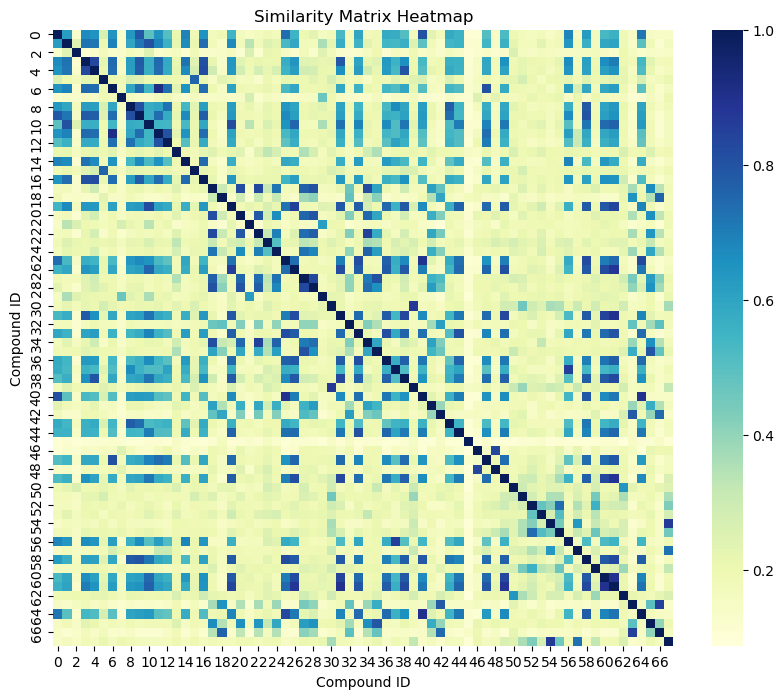

In [5]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 从CSV文件中读取化合物的SMILES信息
data = pd.read_csv('UMP.csv')

# 提取SMILES列
smiles = data['SMILES'].tolist()

# 将SMILES转换为RDKit的分子对象
molecules = [Chem.MolFromSmiles(smile) for smile in smiles]

# 计算分子指纹
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(molecule, 2, nBits=1024) for molecule in molecules]

# 将指纹转换为numpy数组
fingerprints = np.array(fingerprints)

# 计算相似性矩阵
similarity_matrix = pairwise_distances(fingerprints, metric='jaccard')

# 修正相似性矩阵
similarity_matrix = 1 - similarity_matrix

# 将相似性矩阵保存为Excel表格
similarity_df = pd.DataFrame(similarity_matrix, columns=data.index, index=data.index)
similarity_df.to_excel('similarity_matrix.xlsx', index=True)

# 创建相似性矩阵热图
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap="YlGnBu")

# 添加标签和标题
plt.xlabel("Compound ID")
plt.ylabel("Compound ID")
plt.title("Similarity Matrix Heatmap")

# 保存热图为图片文件
plt.savefig("similarity_heatmap.png")

# 显示相似性矩阵热图
plt.show()


In [13]:
smiles_all = []
for index,i in enumerate(smiles_remove):
    m = AllChem.MolFromSmiles(i) #smiles转成mol结构
    if m == None:
        continue
    #Draw.MolToFile(m,"png/"+str(index)+'.png')
    #AllChem.MolToMolFile(m,"mol/"+str(index)+'.mol')
    smile = Chem.MolToSmiles(m)
    smiles_all.append(smile)
print('succes')

df = pd.DataFrame(np.transpose(np.array([smiles_all])),columns=['SMILES','S1'])
df.to_excel('test9_smiles1.xlsx')

succes


ValueError: Shape of passed values is (2200, 1), indices imply (2200, 2)

In [7]:
import os
print(len(os.listdir('png/')))
print(len(os.listdir('mol/')))

201
200


In [43]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 读取Excel文件
df = pd.read_excel('U87MG.xlsx')
smiles = df['SMILES'].tolist()
pic50 = df['PLQY'].values.astype(float)

# 构建分子指纹特征向量
def create_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fingerprint, arr)
    return arr

# 创建数据集
X = np.array([create_fingerprint(s) for s in smiles])
y = np.array(pic50)

# 划分训练集、验证集和测试集
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

num_samples = len(X)
indices = np.arange(num_samples)
np.random.shuffle(indices)

train_split = int(train_ratio * num_samples)
val_split = int((train_ratio + val_ratio) * num_samples)

train_indices = indices[:train_split]
val_indices = indices[train_split:val_split]
test_indices = indices[val_split:]

X_train = torch.tensor(X[train_indices], dtype=torch.float32)
y_train = torch.tensor(y[train_indices], dtype=torch.float32)

X_val = torch.tensor(X[val_indices], dtype=torch.float32)
y_val = torch.tensor(y[val_indices], dtype=torch.float32)

X_test = torch.tensor(X[test_indices], dtype=torch.float32)
y_test = torch.tensor(y[test_indices], dtype=torch.float32)

# 构建FP-GNN模型
class FPGNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FPGNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 设置模型参数和优化器
input_size = 1024
hidden_size = 125
output_size = 1

model = FPGNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.007)

# 训练模型
num_epochs = 1000
batch_size = 32

for epoch in range(num_epochs):
    permutation = torch.randperm(X_train.size()[0])
    for i in range(0, X_train.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_X, batch_y = X_train[indices], y_train[indices]

        optimizer.zero_grad()

        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.unsqueeze(1))
        loss.backward()
        optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# 在验证集上评估模型
model.eval()
with torch.no_grad():
    val_outputs = model(X_val)
    val_loss = criterion(val_outputs, y_val.unsqueeze(1))
    val_r2 = r2_score(y_val, val_outputs.numpy())
    val_mae = mean_absolute_error(y_val, val_outputs.numpy())
    val_rmse = np.sqrt(mean_squared_error(y_val, val_outputs.numpy()))
    print(f'Validation Loss: {val_loss.item()}, R2: {val_r2}, MAE: {val_mae}, RMSE: {val_rmse}')

# 在测试集上评估模型
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test.unsqueeze(1))
    test_r2 = r2_score(y_test, test_outputs.numpy())
    test_mae = mean_absolute_error(y_test, test_outputs.numpy())
    test_rmse = np.sqrt(mean_squared_error(y_test, test_outputs.numpy()))
    print(f'Test Loss: {test_loss.item()}, R2: {test_r2}, MAE: {test_mae}, RMSE: {test_rmse}')

# 批量预测多个SMILES并保存结果到Excel文件


AttributeError: module 'numpy.linalg._umath_linalg' has no attribute '_ilp64'

In [ ]:
df_pred = pd.read_excel('amy.xlsx')
smiles_pred = df_pred['SMILES'].tolist()

pred_results = []
for s in smiles_pred:
    fingerprint = torch.tensor(create_fingerprint(s), dtype=torch.float32).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        prediction = model(fingerprint).item()
    pred_results.append(prediction)

df_pred['Predicted pIC50'] = pred_results
df_pred.to_excel('predictions.xlsx', index=False)

print('预测结果已保存到predictions.xlsx文件中。')

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from bayes_opt import BayesianOptimization

In [2]:
# 读取Excel文件
df = pd.read_excel('AMY.xlsx')
smiles = df['SMILES'].tolist()
pic50 = df['pIC50'].values.astype(float)

# 构建分子指纹特征向量
def create_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fingerprint, arr)
    return arr

# 创建数据集
X = np.array([create_fingerprint(s) for s in smiles])
y = np.array(pic50)

# 划分训练集、验证集和测试集
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

num_samples = len(X)
indices = np.arange(num_samples)
np.random.shuffle(indices)

train_split = int(train_ratio * num_samples)
val_split = int((train_ratio + val_ratio) * num_samples)

train_indices = indices[:train_split]
val_indices = indices[train_split:val_split]
test_indices = indices[val_split:]

X_train = torch.tensor(X[train_indices], dtype=torch.float32)
y_train = torch.tensor(y[train_indices], dtype=torch.float32)

X_val = torch.tensor(X[val_indices], dtype=torch.float32)
y_val = torch.tensor(y[val_indices], dtype=torch.float32)

X_test = torch.tensor(X[test_indices], dtype=torch.float32)
y_test = torch.tensor(y[test_indices], dtype=torch.float32)

In [3]:
class FPGNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FPGNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [4]:
def train_model(hidden_size, lr):
    # 创建模型实例
    model = FPGNN(input_size=1024, hidden_size=int(hidden_size), output_size=1)

    # 设置损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # 训练模型
    num_epochs = 1000
    batch_size = 32

    for epoch in range(num_epochs):
        permutation = torch.randperm(X_train.size()[0])
        for i in range(0, X_train.size()[0], batch_size):
            indices = permutation[i:i+batch_size]
            batch_X, batch_y = X_train[indices], y_train[indices]

            optimizer.zero_grad()

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.unsqueeze(1))
            loss.backward()
            optimizer.step()

    # 在验证集上评估模型
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val.unsqueeze(1))
        val_r2 = r2_score(y_val, val_outputs.numpy())
        val_mae = mean_absolute_error(y_val, val_outputs.numpy())
        val_rmse = np.sqrt(mean_squared_error(y_val, val_outputs.numpy()))

    return -val_r2  # 负R2用于贝叶斯优化的最大化


In [5]:
# 定义超参数搜索范围
pbounds = {'hidden_size': (64, 256),
           'lr': (0.0001, 0.01)}

optimizer = BayesianOptimization(
    f=train_model,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

optimizer.maximize(init_points=5, n_iter=20)  # 进行初始化点和迭代次数的优化

# 获取最佳参数
best_params = optimizer.max['params']
hidden_size = int(best_params['hidden_size'])
lr = best_params['lr']

print('Best Parameters:', best_params)


|   iter    |  target   | hidden... |    lr     |
-------------------------------------------------
| 1         | 0.1366    | 144.1     | 0.007231  |
| 2         | 0.01494   | 64.02     | 0.003093  |
| 3         | -0.2698   | 92.18     | 0.001014  |
| 4         | -0.005078 | 99.76     | 0.003521  |
| 5         | 0.09669   | 140.2     | 0.005434  |
| 6         | -0.3096   | 151.9     | 0.0006231 |
| 7         | 0.0009297 | 134.8     | 0.007943  |
| 8         | 0.05322   | 70.83     | 0.009637  |
| 9         | 0.1567    | 76.88     | 0.008553  |
| 10        | -0.6235   | 81.33     | 0.0001    |
| 11        | 0.1641    | 75.86     | 0.0099    |
| 12        | -0.6582   | 105.0     | 0.0001165 |
| 13        | -0.6153   | 67.49     | 0.0001    |
| 14        | 0.05787   | 142.2     | 0.003128  |
| 15        | 0.1103    | 73.22     | 0.009414  |
| 16        | 0.0952    | 146.9     | 0.009816  |
| 17        | 0.1075    | 130.1     | 0.009969  |
| 18        | 0.2403    | 126.6     | 0.007178  |


In [11]:
# 使用最优参数重新训练模型
best_model = train_model(hidden_size, lr)

# 在测试集上评估模型
best_model.eval()
with torch.no_grad():
    test_outputs = best_model(X_test)
    test_loss = criterion(test_outputs, y_test.unsqueeze(1))
    test_r2 = r2_score(y_test, test_outputs.numpy())
    test_mae = mean_absolute_error(y_test, test_outputs.numpy())
    test_rmse = np.sqrt(mean_squared_error(y_test, test_outputs.numpy()))

print('Test Loss:', test_loss.item())
print('Test R2:', test_r2)
print('Test MAE:', test_mae)
print('Test RMSE:', test_rmse)


AttributeError: 'numpy.float64' object has no attribute 'eval'

In [ ]:
df_pred = pd.read_excel('amy.xlsx')
smiles_pred = df_pred['SMILES'].tolist()

pred_results = []
for s in smiles_pred:
    fingerprint = torch.tensor(create_fingerprint(s), dtype=torch.float32).unsqueeze(0)
    best_model.eval()
    with torch.no_grad():
        prediction = best_model(fingerprint).item()
    pred_results.append(prediction)

df_pred['Predicted pIC50'] = pred_results
df_pred.to_excel('predictions.xlsx', index=False)

print('预测结果已保存到predictions.xlsx文件中。')

In [ ]:
import pandas as pd  
import requests  
from urllib.parse import urlparse  
import os  
  
# 假设您的Excel文件名为 dois.xlsx，并且它有一个包含DOIs的列名为 'DOI'  
EXCEL_FILE = 'DOI.xlsx'  
OUTPUT_FOLDER = 'downloaded_papers'  
SCI_HUB_URL = 'https://www.scihub.net.cn/sci-hub/{doi}' 
  
def download_paper(doi, output_folder):  
    url = SCI_HUB_URL.format(doi=doi)  
    response = requests.get(url, stream=True)  
    if response.status_code == 200:  
        # 假设下载的文件是PDF格式，并以DOI作为文件名  
        filename = f"{doi}.pdf"  
        output_path = os.path.join(output_folder, filename)  
        with open(output_path, 'wb') as file:  
            for chunk in response.iter_content(chunk_size=1024):  
                if chunk:  # filter out keep-alive new chunks  
                    file.write(chunk)  
        print(f"Downloaded {url} to {output_path}")  
    else:  
        print(f"Failed to download {url}")  
  
def main():  
    if not os.path.exists(OUTPUT_FOLDER):  
        os.makedirs(OUTPUT_FOLDER)  
  
    # 读取Excel文件中的DOIs  
    df = pd.read_excel(EXCEL_FILE)  
    for index, row in df.iterrows():  
        doi = row['DOI']  
        if pd.isnull(doi):  
            continue  
        download_paper(doi, OUTPUT_FOLDER)  
  
if __name__ == "__main__":  
    main()

Failed to download https://www.scihub.net.cn/sci-hub/10.1016/S0143-7208(01)00070-5
Failed to download https://www.scihub.net.cn/sci-hub/10.1016/j.dyepig.2010.12.006
Failed to download https://www.scihub.net.cn/sci-hub/10.1016/j.dyepig.2023.111831
Failed to download https://www.scihub.net.cn/sci-hub/10.1016/j.dyepig.2006.04.019
Failed to download https://www.scihub.net.cn/sci-hub/10.1016/j.dyepig.2022.110306
Failed to download https://www.scihub.net.cn/sci-hub/10.1016/j.dyepig.2022.110530
Failed to download https://www.scihub.net.cn/sci-hub/10.1016/j.dyepig.2013.09.008
Failed to download https://www.scihub.net.cn/sci-hub/10.1016/j.dyepig.2017.07.001
Failed to download https://www.scihub.net.cn/sci-hub/10.1016/j.dyepig.2009.01.014
Failed to download https://www.scihub.net.cn/sci-hub/10.1016/j.dyepig.2021.109294
Failed to download https://www.scihub.net.cn/sci-hub/10.1016/j.dyepig.2011.05.011
Failed to download https://www.scihub.net.cn/sci-hub/10.1016/j.dyepig.2018.11.012
Failed to downl

In [ ]:
import pandas as pd  
import requests  
from urllib.parse import urlencode  
import os  
import re  
  
# 假设您的Excel文件名为 dois.xlsx，并且它有一个包含DOIs的列名为 'DOI'  
EXCEL_FILE = 'DOI.xlsx'  
OUTPUT_FOLDER = 'downloaded_papers'  
SCI_HUB_BASE_URL = 'https://www.scihub.net.cn/sci-hub/'  
  
def clean_filename(filename):  
    # 替换文件名中的非法字符  
    return re.sub(r'[\\/:*?"<>|]', '_', filename)  
  
def download_paper(doi, output_folder):  
    # 根据新的sci-hub网址结构构造查询URL  
    params = {'request': doi}  
    url = f"{SCI_HUB_BASE_URL}?{urlencode(params)}"  
      
    response = requests.get(url, stream=True, allow_redirects=True)  
    if response.status_code == 200:  
        # 始终使用DOI作为文件名，但先清理DOI中的非法字符  
        cleaned_doi = clean_filename(doi)  
        filename = f"{cleaned_doi}.pdf"  
        output_path = os.path.join(output_folder, filename)  
        with open(output_path, 'wb') as file:  
            for chunk in response.iter_content(chunk_size=1024):  
                if chunk:  # filter out keep-alive new chunks  
                    file.write(chunk)  
        print(f"Downloaded {url} to {output_path}")  
    else:  
        print(f"Failed to download {url}")  
  
def main():  
    if not os.path.exists(OUTPUT_FOLDER):  
        os.makedirs(OUTPUT_FOLDER)  
      
    # 读取Excel文件中的DOIs  
    df = pd.read_excel(EXCEL_FILE)  
    for index, row in df.iterrows():  
        doi = row['DOI']  
        if pd.isnull(doi):  
            continue  
        download_paper(doi, OUTPUT_FOLDER)  
          
if __name__ == "__main__":  
    main()

Downloaded https://www.scihub.net.cn/sci-hub/?request=10.1016%2FS0143-7208%2801%2900070-5 to downloaded_papers/10.1016_S0143-7208(01)00070-5.pdf
Downloaded https://www.scihub.net.cn/sci-hub/?request=10.1016%2Fj.dyepig.2010.12.006 to downloaded_papers/10.1016_j.dyepig.2010.12.006.pdf
Downloaded https://www.scihub.net.cn/sci-hub/?request=10.1016%2Fj.dyepig.2023.111831 to downloaded_papers/10.1016_j.dyepig.2023.111831.pdf
Downloaded https://www.scihub.net.cn/sci-hub/?request=10.1016%2Fj.dyepig.2006.04.019 to downloaded_papers/10.1016_j.dyepig.2006.04.019.pdf
Downloaded https://www.scihub.net.cn/sci-hub/?request=10.1016%2Fj.dyepig.2022.110306 to downloaded_papers/10.1016_j.dyepig.2022.110306.pdf
Downloaded https://www.scihub.net.cn/sci-hub/?request=10.1016%2Fj.dyepig.2022.110530 to downloaded_papers/10.1016_j.dyepig.2022.110530.pdf
Downloaded https://www.scihub.net.cn/sci-hub/?request=10.1016%2Fj.dyepig.2013.09.008 to downloaded_papers/10.1016_j.dyepig.2013.09.008.pdf
Downloaded https://ww

In [1]:
import pandas as pd
import requests
import os
import re

EXCEL_FILE = 'DOI.xlsx'
OUTPUT_FOLDER = 'downloaded_papers'
SCI_HUB_BASE_URL = 'https://www.sci-hub.yt/'
SCI_HUB_DOWNLOAD_BASE_URL = 'https://www.sci-hub.yt/'

def clean_filename(filename):
    return re.sub(r'[\\/:*?"<>|]', '_', filename)

def get_redirect_url(session, doi):
    data = {'request': doi}
    response = session.post(SCI_HUB_BASE_URL, data=data, allow_redirects=False)
    if response.status_code == 302:  
        return response.headers['Location']
    else:
        return None

def download_paper(session, doi, output_folder):
    redirect_url = get_redirect_url(session, doi)
    if redirect_url:
        if not redirect_url.startswith(SCI_HUB_DOWNLOAD_BASE_URL):
            redirect_url = f"{SCI_HUB_DOWNLOAD_BASE_URL}{doi}"
          
        response = session.get(redirect_url, stream=True, allow_redirects=True)
        if response.status_code == 200:
            cleaned_doi = clean_filename(doi)
            filename = f"{cleaned_doi}.pdf"
            output_path = os.path.join(output_folder, filename)
            with open(output_path, 'wb') as file:
                for chunk in response.iter_content(chunk_size=1024):
                    if chunk:
                        file.write(chunk)
            print(f"Downloaded {redirect_url} to {output_path}")
        else:
            print(f"Failed to download {redirect_url}")
    else:
        print(f"Failed to get redirect URL for DOI: {doi}")

def main():
    if not os.path.exists(OUTPUT_FOLDER):
        os.makedirs(OUTPUT_FOLDER)
      
    with requests.Session() as session:
        df = pd.read_excel(EXCEL_FILE)
        for index, row in df.iterrows():
            doi = row['DOI']
            if pd.isnull(doi):
                continue
            download_paper(session, doi, OUTPUT_FOLDER)

if __name__ == "__main__":
    main()


ConnectionError: HTTPSConnectionPool(host='sci-hub.ru', port=443): Max retries exceeded with url: /10.1016/S0143-7208(01)00070-5 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f9fb0703100>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [4]:
import pandas as pd
import requests
from urllib.parse import quote_plus
import os
import re

EXCEL_FILE = 'DOI.xlsx'
OUTPUT_FOLDER = 'downloaded_papers'
SCI_HUB_BASE_URL = 'https://www.scihub.net.cn/sci-hub/'
SCI_HUB_DOWNLOAD_BASE_URL = 'https://www.sci-hub.yt/'

def clean_filename(filename):
    return re.sub(r'[\\/:*?"<>|]', '_', filename)

def get_redirect_url(session, doi):
    params = {'request': doi}
    url = f"{SCI_HUB_BASE_URL}?{quote_plus(doi)}"
    response = session.get(url, allow_redirects=False)
    if response.status_code == 302:
        return response.headers['Location']
    else:
        return None

def download_paper(doi, output_folder):
    with requests.Session() as session:
        redirect_url = get_redirect_url(session, doi)
        if redirect_url:
            if not redirect_url.startswith(SCI_HUB_DOWNLOAD_BASE_URL):
                redirect_url = f"{SCI_HUB_DOWNLOAD_BASE_URL}{doi}"

            response = session.get(redirect_url, stream=True, allow_redirects=True)
            if response.status_code == 200:
                cleaned_doi = clean_filename(doi)
                filename = f"{cleaned_doi}.pdf"
                output_path = os.path.join(output_folder, filename)
                with open(output_path, 'wb') as file:
                    for chunk in response.iter_content(chunk_size=1024):
                        if chunk:
                            file.write(chunk)
                print(f"Downloaded {redirect_url} to {output_path}")
            else:
                print(f"Failed to download {redirect_url}")
        else:
            print(f"Failed to get redirect URL for DOI: {doi}")

def main():
    if not os.path.exists(OUTPUT_FOLDER):
        os.makedirs(OUTPUT_FOLDER)

    df = pd.read_excel(EXCEL_FILE)
    for index, row in df.iterrows():
        doi = row['DOI']
        if pd.isnull(doi):
            continue
        download_paper(doi, OUTPUT_FOLDER)

if __name__ == "__main__":
    main()


Failed to get redirect URL for DOI: 10.1016/S0143-7208(01)00070-5
Failed to get redirect URL for DOI: 10.1016/j.dyepig.2010.12.006
Failed to get redirect URL for DOI: 10.1016/j.dyepig.2023.111831
Failed to get redirect URL for DOI: 10.1016/j.dyepig.2006.04.019
Failed to get redirect URL for DOI: 10.1016/j.dyepig.2022.110306
Failed to get redirect URL for DOI: 10.1016/j.dyepig.2022.110530
Failed to get redirect URL for DOI: 10.1016/j.dyepig.2013.09.008
Failed to get redirect URL for DOI: 10.1016/j.dyepig.2017.07.001
Failed to get redirect URL for DOI: 10.1016/j.dyepig.2009.01.014
Failed to get redirect URL for DOI: 10.1016/j.dyepig.2021.109294
Failed to get redirect URL for DOI: 10.1016/j.dyepig.2011.05.011
Failed to get redirect URL for DOI: 10.1016/j.dyepig.2018.11.012
Failed to get redirect URL for DOI: 10.1016/j.dyepig.2018.12.050
Failed to get redirect URL for DOI: 10.1016/j.dyepig.2004.12.015
Failed to get redirect URL for DOI: 10.1016/j.dyepig.2016.02.026
Failed to get redirect U

In [ ]:
import pandas as pd
import requests
from urllib.parse import urlencode
import os
import re
from bs4 import BeautifulSoup

# 假设您的Excel文件名为 dois.xlsx，并且它有一个包含DOIs的列名为 'DOI'
EXCEL_FILE = 'DOI.xlsx'
OUTPUT_FOLDER = 'downloaded_papers'
SCI_HUB_BASE_URL = 'https://www.sci-hub.yt/'

def clean_filename(filename):
    # 替换文件名中的非法字符
    return re.sub(r'[\\/:*?"<>|]', '_', filename)

def get_scihub_redirect_url(doi):
    try:
        params = {'request': doi}
        url = f"{SCI_HUB_BASE_URL}?{urlencode(params)}"
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            iframe = soup.find('iframe')
            if iframe:
                redirect_url = iframe['src']
                if not redirect_url.startswith('http'):
                    redirect_url = 'https:' + redirect_url
                return redirect_url
            else:
                print(f"No iframe found for DOI {doi} at URL {url}")
        else:
            print(f"Failed to access {url} with status code: {response.status_code}")
    except requests.exceptions.RequestException as e:
        print(f"Error accessing {SCI_HUB_BASE_URL} for DOI {doi}: {e}")
    return None

def download_paper(doi, output_folder):
    try:
        redirect_url = get_scihub_redirect_url(doi)
        if redirect_url:
            response = requests.get(redirect_url, stream=True, timeout=20)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                pdf_url = None
                for link in soup.find_all('a'):
                    href = link.get('href', '')
                    if href.endswith('.pdf'):
                        pdf_url = href
                        break
                if pdf_url:
                    if not pdf_url.startswith('http'):
                        pdf_url = 'https:' + pdf_url
                    cleaned_doi = clean_filename(doi)
                    filename = f"{cleaned_doi}.pdf"
                    output_path = os.path.join(output_folder, filename)
                    pdf_response = requests.get(pdf_url, stream=True)
                    if pdf_response.status_code == 200:
                        with open(output_path, 'wb') as file:
                            for chunk in pdf_response.iter_content(chunk_size=1024):
                                if chunk:
                                    file.write(chunk)
                        print(f"Downloaded {pdf_url} to {output_path}")
                    else:
                        print(f"Failed to download PDF from {pdf_url} with status code: {pdf_response.status_code}")
                else:
                    print(f"No PDF link found at redirect URL {redirect_url}")
            else:
                print(f"Failed to access redirect URL {redirect_url} with status code: {response.status_code}")
        else:
            print(f"Failed to get redirect URL for DOI: {doi}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading paper for DOI {doi}: {e}")

def main():
    try:
        if not os.path.exists(OUTPUT_FOLDER):
            os.makedirs(OUTPUT_FOLDER)
        
        df = pd.read_excel(EXCEL_FILE)
        for index, row in df.iterrows():
            doi = row['DOI']
            if pd.isnull(doi):
                continue
            print(f"Processing DOI: {doi}")
            download_paper(doi, OUTPUT_FOLDER)
    except Exception as e:
        print(f"Error in main process: {e}")

if __name__ == "__main__":
    main()


Processing DOI: 10.1016/S0143-7208(01)00070-5
Error accessing https://www.sci-hub.yt/ for DOI 10.1016/S0143-7208(01)00070-5: HTTPSConnectionPool(host='sci-hub.ru', port=443): Max retries exceeded with url: /?request=10.1016%2FS0143-7208%2801%2900070-5 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f7adae22b80>: Failed to establish a new connection: [Errno 111] Connection refused'))
Failed to get redirect URL for DOI: 10.1016/S0143-7208(01)00070-5
Processing DOI: 10.1016/j.dyepig.2010.12.006
Error accessing https://www.sci-hub.yt/ for DOI 10.1016/j.dyepig.2010.12.006: HTTPSConnectionPool(host='sci-hub.ru', port=443): Max retries exceeded with url: /?request=10.1016%2Fj.dyepig.2010.12.006 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f7bac059760>: Failed to establish a new connection: [Errno 111] Connection refused'))
Failed to get redirect URL for DOI: 10.1016/j.dyepig.2010.12.006
Processing DOI: 10.1016/j.dyepig.2023.11

In [ ]:
import pandas as pd
import requests
from urllib.parse import urlencode
import os
import re
from bs4 import BeautifulSoup

# Update the Sci-Hub base URL to a working URL
SCI_HUB_BASE_URL = 'https://sci-hub.se/'
EXCEL_FILE = 'DOI.xlsx'
OUTPUT_FOLDER = 'downloaded_papers'

def clean_filename(filename):
    return re.sub(r'[\\/:*?"<>|]', '_', filename)

def get_scihub_redirect_url(doi):
    try:
        params = {'request': doi}
        url = f"{SCI_HUB_BASE_URL}?{urlencode(params)}"
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            iframe = soup.find('iframe')
            if iframe:
                redirect_url = iframe['src']
                if not redirect_url.startswith('http'):
                    redirect_url = 'https:' + redirect_url
                return redirect_url
            else:
                print(f"No iframe found for DOI {doi} at URL {url}")
        else:
            print(f"Failed to access {url} with status code: {response.status_code}")
    except requests.exceptions.RequestException as e:
        print(f"Error accessing {SCI_HUB_BASE_URL} for DOI {doi}: {e}")
    return None

def download_paper(doi, output_folder):
    try:
        redirect_url = get_scihub_redirect_url(doi)
        if redirect_url:
            response = requests.get(redirect_url, stream=True, timeout=20)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                pdf_url = None
                for link in soup.find_all('a'):
                    href = link.get('href', '')
                    if href.endswith('.pdf'):
                        pdf_url = href
                        break
                if pdf_url:
                    if not pdf_url.startswith('http'):
                        pdf_url = 'https:' + pdf_url
                    cleaned_doi = clean_filename(doi)
                    filename = f"{cleaned_doi}.pdf"
                    output_path = os.path.join(output_folder, filename)
                    pdf_response = requests.get(pdf_url, stream=True)
                    if pdf_response.status_code == 200:
                        with open(output_path, 'wb') as file:
                            for chunk in pdf_response.iter_content(chunk_size=1024):
                                if chunk:
                                    file.write(chunk)
                        print(f"Downloaded {pdf_url} to {output_path}")
                    else:
                        print(f"Failed to download PDF from {pdf_url} with status code: {pdf_response.status_code}")
                else:
                    print(f"No PDF link found at redirect URL {redirect_url}")
            else:
                print(f"Failed to access redirect URL {redirect_url} with status code: {response.status_code}")
        else:
            print(f"Failed to get redirect URL for DOI: {doi}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading paper for DOI {doi}: {e}")

def main():
    OUTPUT_FOLDER = 'downloaded_papers'  # Define OUTPUT_FOLDER here
    try:
        if not os.path.exists(OUTPUT_FOLDER):
            os.makedirs(OUTPUT_FOLDER)
        
        df = pd.read_excel(EXCEL_FILE)
        for index, row in df.iterrows():
            doi = row['DOI']
            if pd.isnull(doi):
                continue
            print(f"Processing DOI: {doi}")
            download_paper(doi, OUTPUT_FOLDER)
    except Exception as e:
        print(f"Error in main process: {e}")

if __name__ == "__main__":
    main()


Processing DOI: 10.1016/S0143-7208(01)00070-5
Error accessing https://sci-hub.se/ for DOI 10.1016/S0143-7208(01)00070-5: HTTPSConnectionPool(host='sci-hub.se', port=443): Max retries exceeded with url: /?request=10.1016%2FS0143-7208%2801%2900070-5 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f2d36165af0>: Failed to establish a new connection: [Errno 111] Connection refused'))
Failed to get redirect URL for DOI: 10.1016/S0143-7208(01)00070-5
Processing DOI: 10.1016/j.dyepig.2010.12.006
Error accessing https://sci-hub.se/ for DOI 10.1016/j.dyepig.2010.12.006: HTTPSConnectionPool(host='sci-hub.se', port=443): Max retries exceeded with url: /?request=10.1016%2Fj.dyepig.2010.12.006 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f2d36165400>: Failed to establish a new connection: [Errno 111] Connection refused'))
Failed to get redirect URL for DOI: 10.1016/j.dyepig.2010.12.006
Processing DOI: 10.1016/j.dyepig.2023.111831
Err

In [1]:
import pandas as pd  
import webbrowser  
  
# 读取Excel文件  
excel_path = 'DOI.xlsx'  # 替换为你的Excel文件路径  
df = pd.read_excel(excel_path)  
  
# Chemical Science的基础URL  
base_url = "https://pubs.rsc.org/en/content/articlelanding/"  
  
# 循环遍历DOI并打开对应的网页  
for index, row in df.iterrows():  
    doi = row['DOI']  # 假设你的Excel中DOI列名为'DOI'  
    url = f"{base_url}{doi.replace('/', '-')}"  # 构造文献的URL，注意DOI中的'/'需要被替换为'-'  
    print(f"Opening URL for DOI: {doi}")  
    webbrowser.open(url)  # 在默认浏览器中打开文献页面

Opening URL for DOI: 10.1016/S0143-7208(01)00070-5
Opening URL for DOI: 10.1016/j.dyepig.2010.12.006
Opening URL for DOI: 10.1016/j.dyepig.2023.111831
Opening URL for DOI: 10.1016/j.dyepig.2006.04.019
Opening URL for DOI: 10.1016/j.dyepig.2022.110306
Opening URL for DOI: 10.1016/j.dyepig.2022.110530
Opening URL for DOI: 10.1016/j.dyepig.2013.09.008
Opening URL for DOI: 10.1016/j.dyepig.2017.07.001
Opening URL for DOI: 10.1016/j.dyepig.2009.01.014
Opening URL for DOI: 10.1016/j.dyepig.2021.109294
Opening URL for DOI: 10.1016/j.dyepig.2011.05.011
Opening URL for DOI: 10.1016/j.dyepig.2018.11.012
Opening URL for DOI: 10.1016/j.dyepig.2018.12.050
Opening URL for DOI: 10.1016/j.dyepig.2004.12.015
Opening URL for DOI: 10.1016/j.dyepig.2016.02.026
Opening URL for DOI: 10.1016/j.dyepig.2021.109222
Opening URL for DOI: 10.1016/j.dyepig.2022.110223
Opening URL for DOI: 10.1016/j.dyepig.2012.02.015
Opening URL for DOI: 10.1016/S0143-7208(00)00066-8
Opening URL for DOI: 10.1016/j.dyepig.2004.06.00

restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory


START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2010.12.006"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2006.04.019"


restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory


START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2023.111831"


restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory


START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2022.110306"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2013.09.008"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2022.110530"


restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory


START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2017.07.001"


restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory


START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2011.05.011"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2009.01.014"


restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory


START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2021.109294"


restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory


START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2018.11.012"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2018.12.050"


restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory


START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2016.02.026"


restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory


START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2021.109222"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2004.12.015"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2022.110223"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2012.02.015"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2004.06.002"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-S0143-7208(00)00066-8"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2007.01.018"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-S0143-7208(01)00084-5"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-S0143-7208(01)00018-3"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.

restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) fai

START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2015.04.018"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2018.08.020"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-0143-7208(85)80021-8"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2012.12.001"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2012.04.024"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2006.09.010"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2018.01.016"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2008.11.007"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2022.110656"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.201

restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) fai

START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2013.03.024"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2016.12.017"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2020.108701"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2020.108956"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2009.06.009"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2008.07.010"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2023.111407"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2018.10.012"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2017.03.028"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.201

restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) fai

START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-S0143-7208(03)00028-7"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2014.09.014"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2022.110579"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2023.111732"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2017.03.019"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2006.01.020"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2020.108312"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2003.07.005"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2020.108658"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-0143-7208(9

restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) fai

START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2017.09.045"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2021.109335"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2014.03.036"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2022.110403"


restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory


START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2009.04.005"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2015.05.012"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2012.04.018"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2022.110653"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2014.07.031"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2023.111819"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2011.01.011"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2018.01.004"


restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory


START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2018.05.076"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2019.107708"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2012.06.004"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2010.03.029"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2007.03.007"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2017.05.050"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2016.02.008"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2016.06.028"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2023.111389"


restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory


START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2010.03.034"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2020.108794"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2015.02.001"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2021.109605"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2014.03.018"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2015.11.019"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2023.111324"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2019.107958"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2018.07.044"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.201

restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) fai

START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2013.01.014"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2013.04.023"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2023.111821"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2011.01.006"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2017.05.053"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2022.110612"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2021.109753"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2020.108889"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2014.02.004"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.201

restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) fai

START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2011.10.018"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2014.01.003"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2023.111365"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2017.03.057"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2024.112019"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2013.08.005"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2013.09.043"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2020.108321"


restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory


START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2022.110693"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2020.108861"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2016.07.001"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2009.07.003"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2020.108415"
START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2013.01.013"


restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
restorecon:  lstat(/home/rdkit/.mozilla/firefox/*) failed:  No such file or directory
Error: cannot open display: localhost:12.0
Error: cannot open display: localhost:12.0
Error: cannot open display: localhost:12.0
Error: cannot open display: localhost:12.0
Maximum number of clients reachedError: cannot open display: localhost:12.0
Error: cannot open display: localhost:12.0
Error: cannot open display: localhost:12.0
Maximum number of clients reachedError: cannot open display: localhost:12.0
Error: cannot open display: localhost:12.0
Error: cannot open display: loc

START /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2013.10.004"


Error: cannot open display: localhost:12.0


Crash Annotation GraphicsCriticalError: |[0][GFX1-]: glxtest: Unable to open a connection to the X server (t=28.0413) [GFX1-]: glxtest: Unable to open a connection to the X server
Crash Annotation GraphicsCriticalError: |[0][GFX1-]: glxtest: Unable to open a connection to the X server (t=28.0413) |[1][GFX1-]: glxtest: libEGL initialize failed (t=28.0414) [GFX1-]: glxtest: libEGL initialize failed
Crash Annotation GraphicsCriticalError: |[0][GFX1-]: glxtest: Unable to open a connection to the X server (t=28.0444) [GFX1-]: glxtest: Unable to open a connection to the X server
Crash Annotation GraphicsCriticalError: |[0][GFX1-]: glxtest: Unable to open a connection to the X server (t=28.0444) |[1][GFX1-]: glxtest: libEGL initialize failed (t=28.0445) [GFX1-]: glxtest: libEGL initialize failed
Crash Annotation GraphicsCriticalError: |[0][GFX1-]: glxtest: Unable to open a connection to the X server (t=28.0461) [GFX1-]: glxtest: Unable to open a connection to the X server
Crash Annotation Gra

/usr/bin/xdg-open: line 563: 45951 Segmentation fault      /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2008.11.007"
/usr/bin/xdg-open: line 563: 45948 Segmentation fault      /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2018.01.016"
/usr/bin/xdg-open: line 563: 43394 Segmentation fault      /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2022.110223"
/usr/bin/xdg-open: line 563: 42248 Segmentation fault      /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2021.109294"
/usr/bin/xdg-open: line 563: 51548 Segmentation fault      /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2014.09.032"
/usr/bin/xdg-open: line 563: 51559 Segmentation fault      (core dumped) /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2022.110892"
/usr/bin/xdg-open: line 563: 43585 Segmentation fault      (co

Crash Annotation GraphicsCriticalError: |[0][GFX1-]: Compositor thread not started (true) (t=71.9153) [GFX1-]: Compositor thread not started (true)


/usr/bin/xdg-open: line 563: 44585 Segmentation fault      (core dumped) /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2020.109005"
/usr/bin/xdg-open: line 563: 44637 Segmentation fault      (core dumped) /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2011.01.009"
/usr/bin/xdg-open: line 563: 42094 Segmentation fault      (core dumped) /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2011.05.011"
/usr/bin/xdg-open: line 563: 45964 Segmentation fault      (core dumped) /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2022.110656"
/usr/bin/xdg-open: line 563: 46462 Segmentation fault      /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2010.04.007"
/usr/bin/xdg-open: line 563: 45965 Segmentation fault      /usr/bin/firefox "https://pubs.rsc.org/en/content/articlelanding/10.1016-j.dyepig.2019.03.038"
/usr/bin/xdg-open: l